In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import skimage.measure
from scipy import ndimage as ndi
from scipy.stats import poisson
import pandas as pd

probabilidad = 0.2253

import gc # Garbage collector: Para ayudar a mantener la RAM limpia

In [3]:
# ============================================================================

def regresion_lineal(X, Y):
    """
    Parameters
    ----------
    X : array like
        DESCRIPTION
    Y : array like
        DESCRIPTION
    returns: m y b de la linea mx + b
    """
    N = len(X)
    Delta = N*sum(X**2) - (sum(X))**2
    m = (N*sum(X*Y) - sum(X)*sum(Y))/Delta
    b = (sum(X**2)*sum(Y) - sum(X)*sum(X*Y))/Delta

    return m, b

def fits_finder(directorio=".", extension=".fits"):
    """
    Parameters
    ----------
    directorio : string, optional
        DESCRIPTION. The default is "."
        El directorio "madre" del cual se quieren buscar las imágenes .png
        de todos sus subdirectorios
    extension : string, optional
        DESCRIPTION. The default is ".png"
        La extensión del tipo de archivo que se quiere buscar en los
        subdirectorios. Es necesario usar ".extension": EJ: ".png", ".jpg"
    Returns: string de directorios y archivos .png
    """
    archivos = []
    for root, dirs, files in os.walk(directorio):
        for name in files:
            path = os.path.join(root, name)
            size = os.stat(path).st_size/1000
            if path.endswith(extension) and size < 500:
                archivos.append(path)
    return archivos


def ADU2e(src_path,
          alpha=1.9848e-3,
          beta=-9.77376e-11,
          gamma=1.87747e-15,
          delta=-7.08404e-21,# --> usada en Fano_F_PCC_bkg.c
          #alpha=2.0138e-3, beta=3.23e-11, # --> original de adu2e.py
          ohdu=0,
          save=False):
    """

    From a .fits image, and using the polynomial fit for ADU -> electron
    returns both image data:
        image in ADU's
        image in e- units.

    Parameters
    ----------
    src_path : string
        Directory path of the file
    alpha : float, optional
        By default, alpha = 1.9848e-3
        ref: Tesis Kevin Anderson, tabla 3.1: alpha = 1.99e-3
    beta : float, optional
        By default, beta = -9.77376e-11
        ref: Tesis Kevin Anderson, tabla 3.1: beta = 8.61e-11
    gamma : float, optional
        By default, gamma = 1.87747e-15
        ref: Tesis Kevin Anderson, tabla 3.1: gamma = -6.31e-17
    delta : float, optional
        By default, delta = -7.08404e-21
        ref: Tesis Kevin Anderson, tabla 3.1: delta = 2.73e-23
    ohdu : int, optional
        0, 1, 2, 3 allowed (each sensor of the total sensor)
    save : bool, optional
        When set True, a new fits file in electron units is saved

    Returns
    ----------
    tuple: (numpy array, numpy array)
    """
    with fits.open(src_path) as fits_img:
        ADU_img_data = fits_img[ohdu].data
        e_img_data = np.round(ADU_img_data*alpha 
                              + ADU_img_data**2*beta
                              + ADU_img_data**3*gamma
                              + ADU_img_data**4*delta)
        # =====================================
        # Los datos vienen con valores negativos:
        # filtro los valores negativos y los transformo en 0
        ADU_img_data[ADU_img_data < 0] = 0
        e_img_data[e_img_data < 0] = 0

        if save:
            fits_img[ohdu].data = e_img_data
            tgt_path = src_path.strip(".fits") + "electron_units.fits"
            fits_img.writeto(tgt_path)
    return e_img_data, ADU_img_data


def img2bw(image, lower_thresh=None, upper_thresh=None):
    """
    Binarize the image according to given threshold:
    Parameters
    ----------
    image : numpy array
        DESCRIPTION:
        numpy array with image data
    lowel_trhesh : int - float, optional
        DESCRIPTION.
        minimum threshold for binarizing. If no input, then None
    upper_trhesh : int - float, optional
        DESCRIPTION.
        maximum threshold for binarizing. If no input, uses None
    ----------
    Returns: numpy array of bools
        DESCRIPTION:
        array de numpy con la misma dimensionalidad que el
        input, pero con todos valores booleanos.
    """
    if lower_thresh is None:
        lower_thresh = 0
    if upper_thresh is None:
        upper_thresh = np.max(image) + 1
    return (image >= lower_thresh) & (image <= upper_thresh)


def single_fits2double_fits(src_path, tgt_path="", threshold=1, ohdu=0,
                            save=False):
    """

    From one .fits file generates 2 new fits files.

    Parameters
    ----------
    src_path : string
        Path to the original .fits file or filename
    tgt_path : string
        path to the 2 new .fits files or filename WITHOUT EXTENSION.
        e.g /media/usr/.../image_name <-- correct
        e.g /media/usr/.../image_name.fits <-- incorrect
    threshold : int, optional
        Threshold to start counting electrons. The data will be divided into
        two diferents arrays, one with all pixels having a number of electrons
        greater than threshold and the other one having the rest.
        The default is 1.
    ohdu : int, optional.
        0,1,2,3 allowed (each sensor of the total sensor)
    save : bool, optional.
        If set True, then generates the 2 .fits files with the threshold
        applied
    Returns
    -------
    None.

    """
    electron_fits = ADU2e(src_path, ohdu=ohdu)[0]

    # make some copies of the original data to modify it avoiding aliasing
    elec_minor = electron_fits.copy()
    elec_major = electron_fits.copy()

    # All pixels with a number of electrons > threshold are set to 0
    elec_minor[elec_minor > threshold] = 0
    # All pixels with a number of electrons < threshold are set to 0
    elec_major[elec_major <= threshold] = 0

    # differenciate the minor and major paths
    tgt_path_minor = tgt_path + "minor.fits"
    tgt_path_major = tgt_path + "major.fits"
    if save is True:
        with fits.open(src_path) as fits_img:
            # save elec_minor
            fits_img[ohdu].data = elec_minor
            try:
                fits_img.writeto(tgt_path_minor)
            except OSError as e:
                print(e)
                print("A file with the same name already exists.")
            # save elec_major
            fits_img[ohdu].data = elec_major
            try:
                fits_img.writeto(tgt_path_major)
            except OSError as e:
                print(e)
                print("A file with the same name already exists.")
    return elec_minor, elec_major

In [4]:
"""
author: Santiago Ezequiel Perez
Quien amablemente me pasó estas funciones para usarlas
"""

def get_cluster_info(image, labels):
    """
    Parameters
    ----------
    image : numpy array
        DESCRIPTION:
        Array de numpy con los datos de la imagen
    labels : numpy array
        DESCRIPTION.
        Array de numpy de la misma estructura dimensional que el array
        imagen. Contiene 0 donde no hay features y contiene enteros 
        crecientes para etiquetar (labelear) los features.
    ----------
    Returns: dict
        DESCRIPTION:
        Diccionario con las siguientes keys:
            areas,
            centros,
            coordenadas,
            perimetro,
            energias,
            box
    """
    def image_intensity(region, intensities):
        """
        Es una función interna de get_cluster_info
        Suma las intensidades de una region en unidades de electrones
        """
        return np.sum(intensities[region])

    rps = skimage.measure.regionprops(labels,
                                      intensity_image=image,
                                      cache=False,
                                      extra_properties=[image_intensity])
    areas = [r.area for r in rps]
    energy = [r.image_intensity for r in rps]
    centros = [r.centroid for r in rps]
    coords = [r.coords for r in rps]
    perimetro = [r.perimeter for r in rps]
    
    dic_props = {"areas": areas,
                 "centros": centros,
                 "coordenadas": coords,
                 "perimetro": perimetro,
                 "energias": energy}
    return dic_props

In [5]:
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K"
os.chdir(DIR)
fits_imgs_list = fits_finder(DIR)

In [6]:
#=============================================================================

def image2cluster_info(fits_imgs_list, low_th=2, upp_th=300, ohdu=0, img="o"):
    """
    Extrae la información de los clusters de todas las imágenes y lo guarda en
    listas
    Parameters
    ----------0.81916
    fits_imgs_list : list
        DESCRIPTION.
        lista de directorios donde están las imágenes .fits
    img : str - optional
        DESCRIPTION.
        para indicarle si va a buscar clusters:
            "o": Busca los features en la imagen original.
            "l": Busca los features en la imagen simulada, pero usa los labels
            para de la imagen original.
            "s": Busca los features de la iamgen simulada.
    low_th : int - optional
        DESCRIPTION.
        lower detection threshold
    upp_th : int - optional
        DESCRIPTION.
        Upper detection threshold
    ohdu : int - optional
        DESCRIPTION.
        The HDU data: 0, 1, 2, 3 available
    ----------
    Returns: lista_dics, lista_b_features, lista_img_idxs
        DESCRIPTION:
        lista con la información
    """
    
    # Armo listas donde guardo la info
    lista_dics = []
    lista_n_features = []
    lista_img_idxs = []
    
    # Hardcodeo el mu de la poissoniana
    mu = 0.2253

    # recorro las imagenes que quiero usar
    for i, image in enumerate(fits_imgs_list):
        # Imagen completa
        image_o = ADU2e(image, ohdu=ohdu)[0]
        
        # Imagen con clústers unicamente
        image_s = single_fits2double_fits(image, ohdu=ohdu)[1]
        # Le agrego ruido a la imagen con clusters unicamente
        image_s += poisson.rvs(mu, size=(50, 493))

        # Binarizo ambas imagenes:
        image_o_bw = img2bw(image_o, lower_thresh=low_th, upper_thresh=upp_th)
        image_s_bw = img2bw(image_s, lower_thresh=low_th, upper_thresh=upp_th)

        # Genero las labels y también guardo el número de features
        label_im_o, n_features_o = ndi.label(image_o_bw,
                                             structure=[[0, 1, 0],
                                                        [1, 1, 1],
                                                        [0, 1, 0]])
        label_im_s, n_features_s = ndi.label(image_s_bw,
                                             structure=[[0, 1, 0],
                                                        [1, 1, 1],
                                                        [0, 1, 0]])

        # Armo el diccionario con información que devuelve get_cluster_size_etc
        if img == "o":
            dic = get_cluster_info(image_o, label_im_o)
            n_features = n_features_o
        elif img == "l":
            dic = get_cluster_info(image_s, label_im_o)
            n_features = n_features_o
        elif img == "s":
            dic = get_cluster_info(image_s, label_im_s)
            n_features = n_features_s
        else:
            print("opción incorrecta: Solo 'o', 'l', 's' son válidos")
            return 0
        lista_dics.append(dic)
        lista_n_features.append(n_features)
        lista_img_idxs.append(np.ones(n_features)*i)
        # Printeo el progreso del ciclo for
        print("\r%.2f%%" % (100*(i+1)/925), end = "")
    
    return lista_dics, lista_img_idxs


def df_gen(lista_dics, lista_img_idxs):
    """
    Esta función arma a partir de la listas de información un DataFrame de 
    pandas para manipular la información más comodamente
    Parameters
    ----------
    lista_dics : list
        DESCRIPTION:
        lista de diccionarios
    lista_img_idxs : list
        DESCRIPTION.
        lista de índices para identificar una misma imagen
    ----------
    Returns: pd.DataFrame
        DESCRIPTION:
        DataFrame con toda la información de las imágenes
    """
    
    # armo listas para meter los datos
    energias = []
    areas = []
    centros = []
    perimetros = []
    
    # meto los datos en las listas
    for dics in lista_dics:
        energias += dics["energias"]
        areas += dics["areas"]
        centros += dics["centros"]
        perimetros += dics["perimetro"]
        
    # concateno los índices para que sea un solo array
    lista_img_idxs = np.concatenate(lista_img_idxs)
    
    # Armo el dicionario
    diccionario = {}
    diccionario["img_idx"] = lista_img_idxs
    diccionario["energia"] = energias
    diccionario["area"] = areas
    diccionario["centro"] = centros
    diccionario["perimetro"] = perimetros
    
    return pd.DataFrame.from_dict(diccionario)

In [7]:
# =============================================================================
lista_data_dics, lista_data_idx_o = image2cluster_info(fits_imgs_list, img="o",
                                                       low_th=2, upp_th=None,
                                                       ohdu=0)
df_data = df_gen(lista_data_dics, lista_data_idx_o)
del lista_data_dics, lista_data_idx_o
gc.collect()

100.00%

0

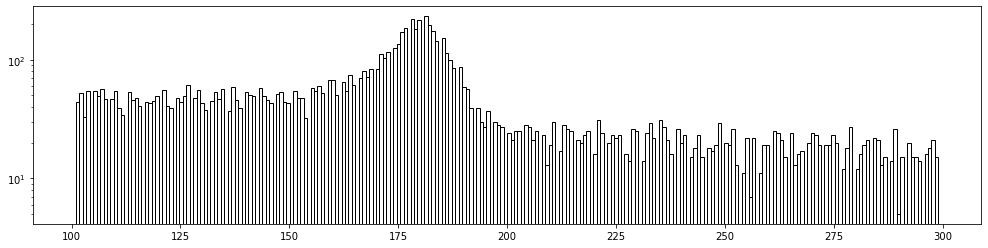

In [8]:
energia_data = df_data[(df_data["energia"]>100) & (df_data["energia"]<300)]["energia"]

plt.figure(figsize=(17,4))
plt.hist(energia_data, bins=250, fill=False);
plt.yscale("log")

# BORDES

Voy a hacer paso a paso el cálculo de los bordes, gracias a más códigos que me pasó Santiago Perez

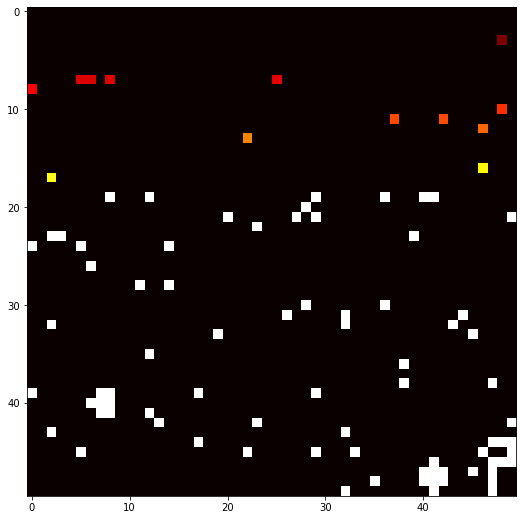

In [9]:
# agarro una imagen random
img_dir = fits_imgs_list[213]

# La transformo a matriz numpy

img = ADU2e(img_dir)[0]

# binarizo
img_bw = img2bw(img, lower_thresh=2)

# Structura
struc = [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]

# Le busco los labels


img_label, count = ndi.label(img_bw, structure=struc)

# Miro solo una parte de la imagen

plt.figure(figsize=(9,9))
plt.imshow(img_label[0:50, 100:150], cmap="hot", vmin=0, vmax=200)

Dilato los clusters.

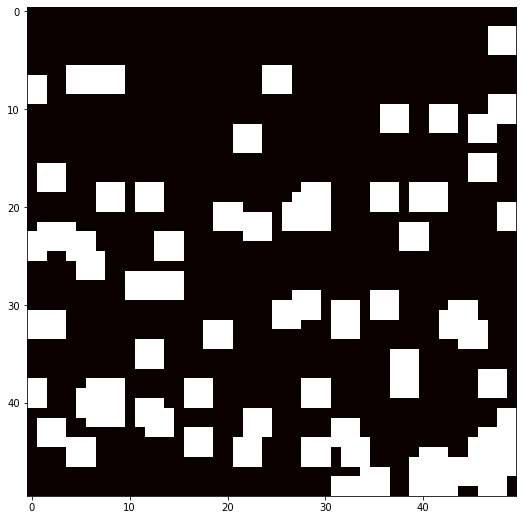

In [10]:
img_dilatada = ndi.morphology.binary_dilation(img_label, structure=struc)
plt.figure(figsize=(9, 9))
plt.imshow(img_dilatada[0:50, 100:150], cmap="hot")

Ahora miro la diferencia entre la imagen dilatada y la original

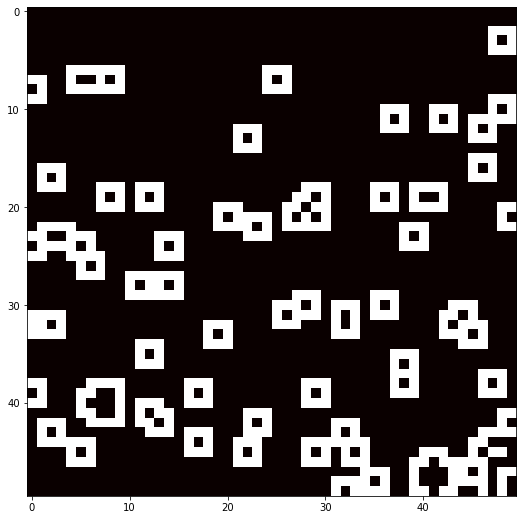

In [11]:
plt.figure(figsize=(9, 9))
bordes = (img_dilatada*1.0 - img_bw*1.0)
plt.imshow(bordes[0:50, 100:150], cmap="hot")

La imagen completa de los bordes

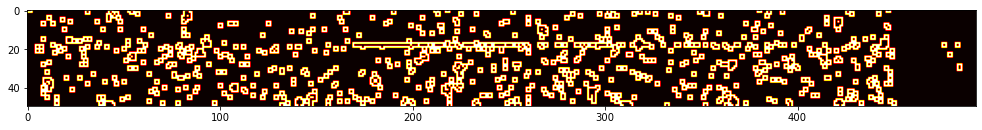

In [12]:
plt.figure(figsize=(17, 2))
plt.imshow(bordes, cmap="hot")

La relación entre los bordes y la cantidad total de píxeles es

In [13]:
np.sum(bordes)/bordes.size

0.21192697768762678

### ¿Qué quiero hacer?

- Tomo todas las imágenes y las paso a unidades de electrones usando como threshold 2
- Me quedo solo con los clusters que tienen carga enre 160 y 200 electrones. Todo lo demás lo mato.
- Dilato esos clusters
- Armo la máscara a partir de los clusters dilatados y la imagen sin dilatar
- Uso la máscara sobre las images completas y cuento la carga que hay sobre ellos.
- Comparo la cantidad de carga sobre los bordes vs la carga esperada en esa cantidad de píxeles por dark current

In [38]:
def image_intensity(region, intensities):
        """
        Es una función interna de get_cluster_info
        Suma las intensidades de una region en unidades de electrones
        """
        return np.sum(intensities[region])

# agarro una imagen random
carga = 0
pixeles = 0
clusters_per_pic = []
for i, image in enumerate(fits_imgs_list):
    cluster_index = []
    # Cargo la iamgen original, equivalente a epix 0.5
    img = ADU2e(image)[0]
    # binarizo con thresh=2 equivalente a epix 1.5
    img_bw = img2bw(img, lower_thresh=2)
    # Structura
    struc = [[1, 1, 1],
             [1, 1, 1],
             [1, 1, 1]]

    # Le busco los labels
    img_label, count = ndi.label(img_bw, structure=struc)
    
    # Usando los labels, voy a buscar los clusters que cumplan que
    # tienen entre 160 y 200 electrones
    rps = skimage.measure.regionprops(img_label,
                                      intensity_image=img,
                                      cache=False,
                                      extra_properties=[image_intensity])
    
    # Aprovecho y cuento la cantidad de clusters de 180 por imagen
    n_clusters = 0
    for r in rps:
        intens = r.image_intensity
        if intens >= 160 and intens <=200:
            cluster_index.append(1)
            n_clusters += 1
        else:
            cluster_index.append(0)
    # Appendeo el numero total de clusters contados por imagen
    clusters_per_pic.append(n_clusters)
    
    # Ahora, buscando en qué índice de la lista cluster_index hay 1's,
    # puedo matchearlo con el label del mismo valor que el número del
    # índice. Esos labels van a sobrevivir, los demás van a ser 0.

    # para eso, transformo la lista en array de numpy
    cluster_index_np = np.array(cluster_index)

    # Lista de vals/indices donde los clusters tienen ese rango de carga
    values = list(np.where(cluster_index_np==1)[0])

    # Me armo una lista con condiciones (arrays True/False)
    conditions = [img_label == value for value in values]

    # Ahora me armo la máscara solo en los clusters deseados, para eso
    # redefino la img_label. Equivale a haber encontrado solo clusters con
    # carga entre 160 y 200 electrones
    try:
        img_label = np.select(conditions, values)
    except ValueError as e:
        print("\nimagen %i sin clusters entre 160 y 200 electrones" % i)
        pass

    # Ahora dilato esos clusters
    img_dilat = ndi.morphology.binary_dilation(img_label, structure=struc)

    # Transformo a 0's y 1's la img_dilatada
    img_dilat = img_dilat*1#np.where(img_dilat!=0, 1, 0)

    # Transformo a 0's y 1's la img_label
    img_label = np.where(img_label!=0, 1, 0)

    # Hago la máscara usando la imagen dilatada y img_label
    mask = img_dilat - img_label

    # Se la aplico a la imagen original y sumo la carga
    img_bordes = img*mask
    carga += np.sum(img_bordes)

    # Se la aplico a la binarizada
    pixeles += np.sum(mask)
    print("\r %.2f%%" % ((i+1)*100/len(fits_imgs_list)), end="")

carga_oscura = pixeles*0.2235
diff_carga = carga_oscura - carga
mean_cluster = np.mean(clusters_per_pic)
std_cluster = np.std(clusters_per_pic)
print("\nCantidad de carga en bordes: %i" % carga)
print("Cantidad de carga esperada por corrientes oscuras: %i" % carga_oscura)
print("Diferencia de carga: %i" % diff_carga)
print("Diferencia promedio en 925 imágenes: %.2f" % (diff_carga/925))
print("\nPromedio clusters de 180 p/ imagen: %.2f +/- %.2f" % (mean_cluster, std_cluster))


imagen 0 sin clusters entre 160 y 200 electrones
 7.14%
imagen 66 sin clusters entre 160 y 200 electrones
 7.35%
imagen 68 sin clusters entre 160 y 200 electrones
 8.22%
imagen 76 sin clusters entre 160 y 200 electrones
 12.86%
imagen 119 sin clusters entre 160 y 200 electrones
 25.51%
imagen 236 sin clusters entre 160 y 200 electrones
 26.92%
imagen 249 sin clusters entre 160 y 200 electrones
 31.78%
imagen 294 sin clusters entre 160 y 200 electrones
 39.14%
imagen 362 sin clusters entre 160 y 200 electrones
 46.16%
imagen 427 sin clusters entre 160 y 200 electrones
 46.81%
imagen 433 sin clusters entre 160 y 200 electrones
 49.19%
imagen 455 sin clusters entre 160 y 200 electrones
 58.92%
imagen 545 sin clusters entre 160 y 200 electrones
 60.97%
imagen 564 sin clusters entre 160 y 200 electrones
 68.76%
imagen 636 sin clusters entre 160 y 200 electrones
 69.41%
imagen 642 sin clusters entre 160 y 200 electrones
 84.43%
imagen 781 sin clusters entre 160 y 200 electrones
 84.97%
imag

In [31]:
carga = 0
pixeles = 0
cluster_index = [h

image = fits_imgs_list[924]
# Cargo la imagen
img = ADU2e(image)[0]
# binarizo con thresh=2 equivalente a epix 1.5
img_bw = img2bw(img, lower_thresh=2)
# Structura
struc = [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]

# Le busco los labels
img_label, count = ndi.label(img_bw, structure=struc)

# Usando los labels, voy a buscar los clusters que cumplan que
# tienen entre 160 y 200 electrones
rps = skimage.measure.regionprops(img_label,
                                  intensity_image=img,
                                  cache=False,
                                  extra_properties=[image_intensity])

for r in rps:
    intens = r.image_intensity
    if intens >= 160 and intens <=200:
        cluster_index.append(1)
    else:
        cluster_index.append(0)

# Ahora, buscando en qué índice de la lista cluster_index hay 1's,
# puedo matchearlo con el label del mismo valor que el número del
# índice. Esos labels van a sobrevivir, los demás van a ser 0.

# para eso, transformo la lista en array de numpy
cluster_index = np.array(cluster_index)

# Busco los vals/indices donde los clusters tienen ese rango de carga
values = list(np.where(cluster_index==1)[0])

# Me armo una lista con condiciones (arrays True False)
conditions = [img_label == value for value in values]

# Ahora me armo la máscara solo en los clusters deseados, para eso
# redefino la img_label
img_label = np.select(conditions, values)

# Ahora dilato
img_dilat = ndi.morphology.binary_dilation(img_label, structure=struc)

# Transformo a 0's y 1's la img_dilatada
img_dilat = np.where(img_dilat!=0, 1, 0)

# Transformo a 0's y 1's la img_label
img_label = np.where(img_label!=0, 1, 0)

# Hago la máscara usando la imagen dilatada y img_label
mask = img_dilat - img_label

# Se la aplico a la imagen original y sumo la carga
img_bordes = img*mask
carga += np.sum(img_bordes)

# Se la aplico a la binarizada
pixeles += np.sum(mask)
print("\nCantidad de carga en bordes: %i" % carga)
print("Cantidad de carga esperada por corrientes oscuras: %i" %(pixeles*0.2235))


Cantidad de carga en bordes: 5
Cantidad de carga esperada por corrientes oscuras: 6


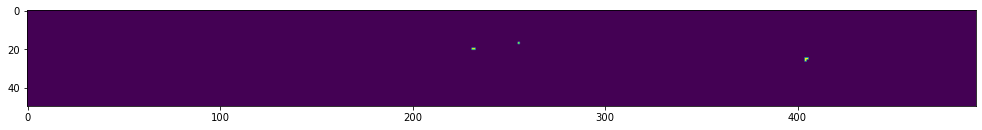

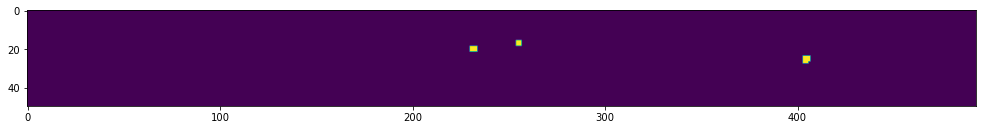

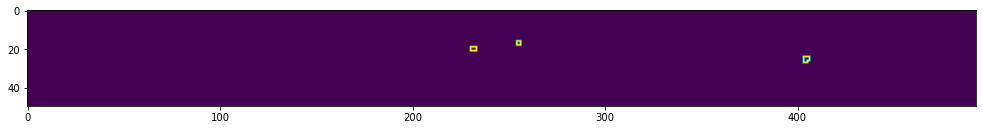

In [33]:
plt.figure(figsize=(17,2))
plt.imshow(img_label)
plt.figure(figsize=(17,2))
plt.imshow(img_dilat)
plt.figure(figsize=(17,2))
plt.imshow(mask)

In [40]:
def border_events(img_path, low_th=2, ohdu=0):
    # Cargo la imagen
    img = ADU2e(img_path, ohdu=ohdu)[0]
    # binarizo con thresh=2 equivalente a epix 1.5
    img_bw = img2bw(img, lower_thresh=2)
    # Structura
    struc = [[1, 1, 1],
             [1, 1, 1],
             [1, 1, 1]]

    # Le busco los labels
    img_label, count = ndi.label(img_bw, structure=struc)
    
    # Usando los labels, voy a buscar los clusters que cumplan que
    # tienen entre 160 y 200 electrones
    
    def image_intensity(region, intensities):
        """
        Es una función interna de get_cluster_info
        Suma las intensidades de una region en unidades de electrones
        """
        return np.sum(intensities[region])
    
    rps = skimage.measure.regionprops(img_label,
                                      intensity_image=img,
                                      cache=False,
                                      extra_properties=[image_intensity])
    
    # Aprovecho y cuento la cantidad de clusters de 180 por imagen
    cluster_index = []
    n_clusters = 0
    for r in rps:
        intens = r.image_intensity
        if intens >= 160 and intens <=200:
            cluster_index.append(1)
            n_clusters += 1
        else:
            cluster_index.append(0)

    # Ahora, buscando en qué índice de la lista cluster_index hay 1's,
    # puedo matchearlo con el label del mismo valor que el número del
    # índice. Esos labels van a sobrevivir, los demás van a ser 0.

    # para eso, transformo la lista en array de numpy
    cluster_index_np = np.array(cluster_index)

    # Lista de vals/indices donde los clusters tienen ese rango de carga
    values = list(np.where(cluster_index_np==1)[0])

    # Me armo una lista con condiciones (arrays True/False)
    conditions = [img_label == value for value in values]

    # Ahora me armo la máscara solo en los clusters deseados, para eso
    # redefino la img_label. Equivale a haber encontrado solo clusters con
    # carga entre 160 y 200 electrones
    try:
        img_label = np.select(conditions, values)
    except ValueError as e:
        print("imagen %i sin clusters entre 160 y 200 electrones" % i)
        pass

    # Ahora dilato esos clusters
    img_dilat = ndi.morphology.binary_dilation(img_label, structure=struc)

    # Transformo a 0's y 1's la img_dilatada
    img_dilat = img_dilat*1#np.where(img_dilat!=0, 1, 0)

    # Transformo a 0's y 1's la img_label
    img_label = np.where(img_label!=0, 1, 0)

    # Hago la máscara usando la imagen dilatada y img_label
    mask = img_dilat - img_label

    # Se la aplico a la imagen original y sumo la carga
    img_bordes = img*mask
    carga = np.sum(img_bordes)

    # Se la aplico a la binarizada
    pixeles = np.sum(mask)
    
    return carga, pixeles, n_clusters


In [45]:
# ============================================================================

cargas_totales = 0
pixeles_totales = 0
clusters_per_pic = []
for i, image in enumerate(fits_imgs_list):
    carga, pixeles, n_clusters = border_events(image, low_th=2, ohdu=0)
    clusters_per_pic.append(n_clusters)
    cargas_totales += carga
    pixeles_totales += pixeles
    print("\r %.2f%% Completado. -" % ((i+1)*100/len(fits_imgs_list)), end="")

print("\nCantidad de carga en bordes: %i" % cargas_totales)
print("Cantidad de carga esperada por corrientes oscuras: %i" % carga_oscura)
print("Diferencia de carga: %i" % diff_carga)
print("Diferencia promedio en 925 imágenes: %.2f" % (diff_carga/925))
print("\nPromedio clusters de 180 p/ imagen: %.2f +/- %.2f" % (mean_cluster, std_cluster))

imagen 0 sin clusters entre 160 y 200 electrones
 7.14% Completado. -imagen 66 sin clusters entre 160 y 200 electrones
 7.35% Completado. -imagen 68 sin clusters entre 160 y 200 electrones
 8.22% Completado. -imagen 76 sin clusters entre 160 y 200 electrones
 12.86% Completado. -imagen 119 sin clusters entre 160 y 200 electrones
 25.51% Completado. -imagen 236 sin clusters entre 160 y 200 electrones
 26.92% Completado. -imagen 249 sin clusters entre 160 y 200 electrones
 31.78% Completado. -imagen 294 sin clusters entre 160 y 200 electrones
 39.14% Completado. -imagen 362 sin clusters entre 160 y 200 electrones
 46.16% Completado. -imagen 427 sin clusters entre 160 y 200 electrones
 46.81% Completado. -imagen 433 sin clusters entre 160 y 200 electrones
 49.19% Completado. -imagen 455 sin clusters entre 160 y 200 electrones
 58.92% Completado. -imagen 545 sin clusters entre 160 y 200 electrones
 60.97% Completado. -imagen 564 sin clusters entre 160 y 200 electrones
 68.76% Completado. -